# Implementación del muestreo aleatorio

En este programa implementaremos los elementos necesarios para realizar planificaciones basadas en muestreo. Para ello requeriremos:

1. Crear un conjunto de polígonos que representen los obstáculos en el ambiente.
2. Muestrear puntos en tres dimensiones.
3. Eliminar puntos que caigan en una región de obstáculos poligonal.


In [1]:
# Importamos paquetes necesarios
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# utilizaremos la librería shapely para representar los polígonos del ambiente
from shapely.geometry import Polygon, Point

%matplotlib inline 
plt.rcParams['figure.figsize'] = 12, 12

In [2]:
# Los obstáculos están especificados en el siguiente archivo.
filename = 'data_reduced.csv'
data = np.loadtxt(filename, delimiter=',', dtype=np.float64, skiprows=2)

## Crear obstáculos

Para simplificar el proceso, representaremos cada obstáculos mediante una representación de dos partes. La primera será la base de la figura; en este ejemplo supondremos figuras rectangulares. La segunda será la altura. De esta forma, un punto $(x, y, z)$ está en colisión si $(x, y)$ están dentro de la base polygonal y la altura $z$ es menor que la altura del obstáculo.

In [3]:
def extract_polygons(data):
    # Construye un conjunto de polígonos a partir de los datos de obstáculo
    polygons = []
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        
        # Tarea: Extraer los límites de los obstáculos
        obstacle = [north - d_north, north + d_north, east - d_east, east + d_east]
        # NOTE: The order of the points matters since
        # `shapely` draws the sequentially from point to point.
        # If the area of the polygon is 0 you've likely got a weird order.
        corners = [(obstacle[0], obstacle[2]), (obstacle[0], obstacle[3]), (obstacle[1], obstacle[3]), (obstacle[1], obstacle[2])]
        
        # Tarea: Determinar la altura del polígono
        height = alt + d_alt

        # Tarea: Definir polígonos a partir de las esquinas
        #poly = None
        #polygons.append((poly, height))
        poly = Polygon(corners)
        polygons.append((poly, height))

    return polygons

In [4]:
polygons = extract_polygons(data)

## Muestrear puntos 3D

A continuación generaremos un conjunto de muestras aleatorias dentro de los límites del mapa. 

Lo primero es obtener los límites. Dichos límites los podemos obtener a partir de los valores máximos y mínimos del mapa. Para ello podemos hacer uso de las funciones de *numpy* *min* y *max*. Recordemos también que cada renglón de datos contiene:
[posX, posY, posZ, halfSizeX, halfSizeY, halfSizeZ]. Por lo tanto, debemos combinar la posición con el ancho del objeto.

In [5]:
xmin = np.min(data[:, 0] - data[:, 3])
xmax = np.max(data[:, 0] + data[:, 3])

ymin = np.min(data[:, 1] - data[:, 4])
ymax = np.max(data[:, 1] + data[:, 4])

zmin = 0
# Limit the z axis for the visualization
zmax = 10

print("X")
print("min = {0}, max = {1}\n".format(xmin, xmax))

print("Y")
print("min = {0}, max = {1}\n".format(ymin, ymax))

print("Z")
print("min = {0}, max = {1}".format(zmin, zmax))

X
min = -295.2389, max = 304.7612

Y
min = -104.23155, max = 401.658113

Z
min = 0, max = 10


A continuación muestrearemos el espacio usando una función de distribución uniforme. La distribución uniforme nos garantiza que eventualmente muestrearemos todo el espacio. Para ello podemos usar la función de *numpy* *random.uniform*.

In [6]:
num_samples = 100

xvals = np.random.uniform(xmin, xmax, num_samples)
yvals = np.random.uniform(ymin, ymax, num_samples)
zvals = np.random.uniform(zmin, zmax, num_samples)

samples = list(zip(xvals, yvals, zvals))

In [7]:
samples[:5]

[(128.8338377445611, 278.5103368721981, 0.43892543219074653),
 (152.43740435103246, 67.6209737168997, 8.12564886788439),
 (-73.36365726685187, 153.56732859218536, 5.4563368359557),
 (275.94820809806555, 56.62467707146442, 7.530989129744338),
 (15.620610678641128, 216.28249157808463, 3.987326212645824)]

## Eliminar puntos que colisionan con los obstáculos

Prior to remove a point we must determine whether it collides with any obstacle. Complete the `collides` function below. It should return `True` if the point collides with *any* obstacle and `False` if no collision is detected.

In [8]:
def collides(polygons, point):   
    # Tarea: Determinar cuáles puntos están en colisión con los polígonos
    collide = False
    x,y,z = point
    p = Point(x, y)
    for poly in polygons:
        polygon, height = poly
        if polygon.contains(p):
            if z < height:
                collide = True
            
    return collide

Use `collides` for all points in the sample.

In [9]:
t0 = time.time()
to_keep = []
for point in samples:
    if not collides(polygons, point):
        to_keep.append(point)
time_taken = time.time() - t0
print("Time taken {0} seconds ...", time_taken)

Time taken {0} seconds ... 0.1861438751220703


In [10]:
print(len(to_keep), "puntos válidos.")

62 puntos válidos.


## Visualizar los puntos

Ahora solo visualizaremos los puntos.

In [11]:
from grid import create_grid
grid = create_grid(data, zmax, 1)

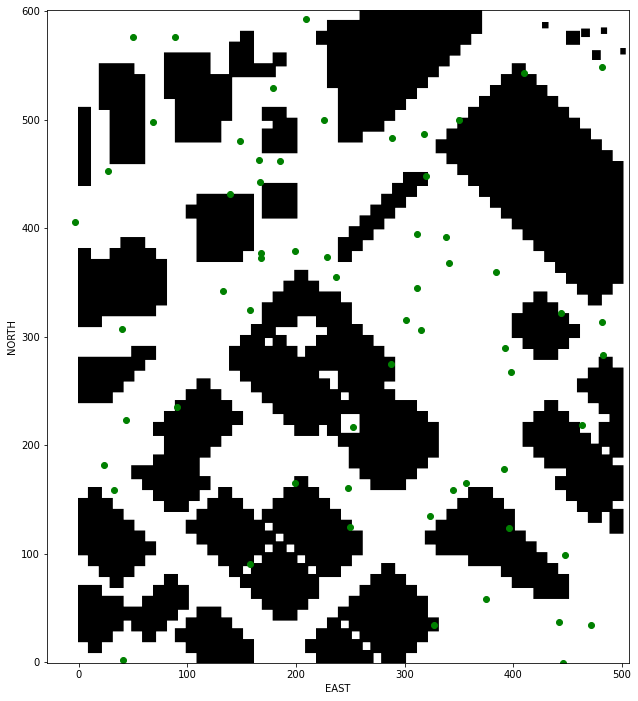

In [12]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# Draw points
all_pts = np.array(to_keep)
north_vals = all_pts[:,0]
east_vals = all_pts[:,1]
plt.scatter(east_vals - emin, north_vals - nmin, c='green')

plt.ylabel('NORTH')
plt.xlabel('EAST')

plt.show()

## Epilogue

You may have noticed removing points can be quite lengthy. In the implementation provided here we're naively checking to see if the point collides with each polygon when in reality it can only collide with one, the one that's closest to the point. The question then becomes 

"How do we efficiently find the closest polygon to the point?"

One such approach is to use a *[k-d tree](https://en.wikipedia.org/wiki/K-d_tree)*, a space-partitioning data structure which allows search queries in $O(log(n))$. The *k-d tree* achieves this by cutting the search space in half on each step of a query.

This would bring the total algorithm time down to $O(m * log(n))$ from $O(m*n)$.

The scikit-learn library has an efficient implementation [readily available](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree).